<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Binary_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import copy
import torch
import numpy as np
import torchvision
import torchsummary
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw

#1.Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle competitions download -c histopathologic-cancer-detection
!unzip \*.zip && rm *.zip

0    59.496875
1    40.503125
Name: label, dtype: float64


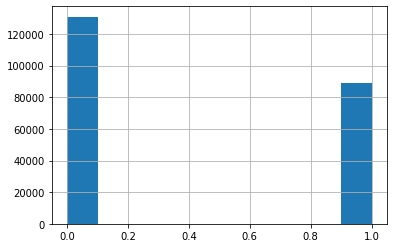

In [ ]:
path2csv = './train_labels.csv'
labels_df = pd.read_csv(path2csv)
print(100*labels_df['label'].value_counts()/len(labels_df))
labels_df['label'].hist()

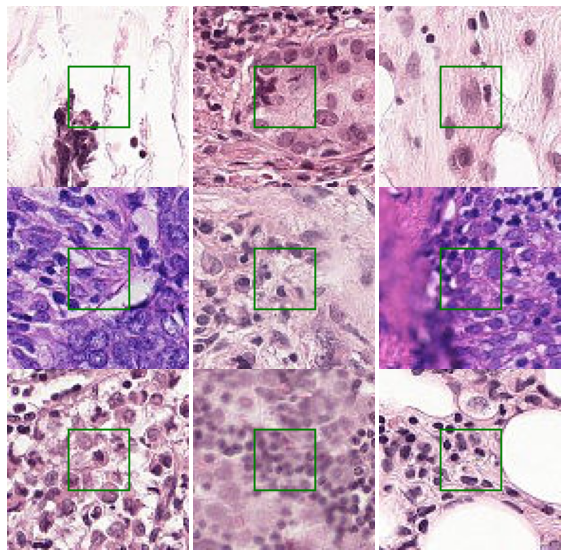

In [ ]:
malignantIds = labels_df.loc[labels_df['label'] == 1]['id'].values
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3
color=True
for i , id in enumerate(malignantIds[:nrows*ncols]):
  full_path = os.path.join('/content/train', id+'.tif')
  img = Image.open(full_path)
  draw = ImageDraw.Draw(img)
  draw.rectangle(((32, 32), (64, 64)), outline='green')
  plt.subplot(nrows, ncols, i+1)
  if color:
    plt.imshow(np.array(img))
  else:
    plt.imshow(np.array(img)[:,:,0], cmap='gray')
  plt.axis('off')

In [ ]:
torch.manual_seed(32)

class HistoCancerDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, transform, data_type='train'):
    self.data_type = data_type
    path2data = os.path.join(data_dir, self.data_type)
    filenames = os.listdir(path2data)
    self.full_filenames = [os.path.join(path2data, f) for f in filenames]

    if self.data_type == 'train':
      path2csvLabels = os.path.join(data_dir, f'{self.data_type}_labels.csv')
      labels_df = pd.read_csv(path2csvLabels)
      labels_df.set_index('id', inplace=True)
      self.labels = [labels_df.loc[f_name[:-4]].values[0] for f_name in filenames]
    self.transform = transform
  
  def __len__(self):
    return len(self.full_filenames)

  def __getitem__(self, idx):
    image = Image.open(self.full_filenames[idx])
    image = self.transform(image)
    if self.data_type == 'train':
      return image, self.labels[idx]
    return image

In [ ]:
data_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = HistoCancerDataset('/content', data_transformer, 'train')

In [ ]:
len_train = int(0.8 * len(train_dataset))
len_val = len(train_dataset) - len_train
train_ds, val_ds = torch.utils.data.random_split(train_dataset, [len_train, len_val])

In [ ]:
def show(img, y, color=True):
  npimg = img.numpy()
  npimg_tr = npimg.transpose((1, 2, 0))
  if color:
    plt.imshow(npimg_tr, interpolation='nearest')
  else:
    plt.imshow(npimg_tr[:, : 0], interpolation='nearest', cmao='gray')
  plt.title(f'Label: {y}')  
  
def show_random(ds, grid_size=4, color=True):
  rnd_inds = np.random.randint(0, len(ds), grid_size)

  x_grid_train = [ds[i][0] for i in rnd_inds]
  y_grid_train = [ds[i][1] for i in rnd_inds]

  x_grid_train = torchvision.utils.make_grid(x_grid_train, nrow=grid_size, padding=2)
  plt.rcParams['figure.figsize'] = (10.0, 5)
  show(x_grid_train, y_grid_train, color)  

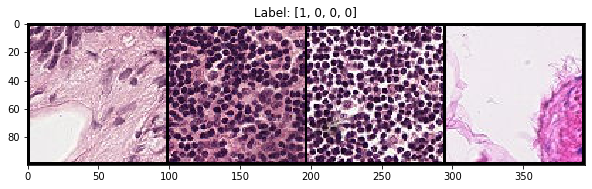

In [ ]:
show_random(train_ds)

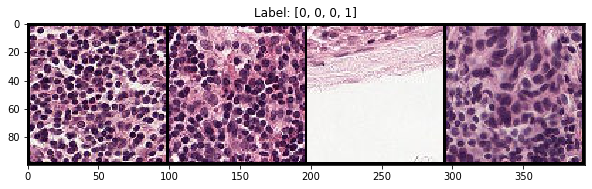

In [ ]:
show_random(val_ds)

In [ ]:
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.ToTensor()])

val_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_ds.transform = train_transformer
val_ds.transform = val_transformer

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=32,
                                       shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,
                                     batch_size=32,
                                     shuffle=False)

#2.Model

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
def accuracy(labels, out):
  return np.sum(labels==out)/len(labels)


def findConv2dOutShape(h_in, w_in, conv,pool=2):
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation
  h_out = np.floor((h_in + (2*padding[0]) - dilation[0]*(kernel_size[0]-1) - 1) / stride[0] + 1)
  w_out = np.floor((w_in + (2*padding[1]) - dilation[1]*(kernel_size[1]-1) - 1) / stride[1] + 1)

  if pool:
    h_out = h_out / pool
    w_out = w_out / pool
  return int(h_out), int(w_out)  
  

In [ ]:
cnv = torch.nn.Conv2d(65, 80, kernel_size=3, padding=5, stride=5)
h, w = findConv2dOutShape(906, 106, cnv)
print(h,w)

91 11


In [ ]:
class Net(torch.nn.Module):
  def __init__(self, params):
    super(Net, self).__init__()
    c, h, w = params['input_shape']
    init_f = params['initial_filters']
    num_fc1 = params['num_fc1']
    num_classes = params['num_classes']
    self.dropout_rate = params['dropout_rate']
    self.conv1 = torch.nn.Conv2d(c, init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv1)
    self.conv2 = torch.nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv2)
    self.conv3 = torch.nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv3)
    self.conv4 = torch.nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv4)
    self.num_flatten = h*w*8*init_f
    self.fc1 = torch.nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = torch.nn.Linear(num_fc1, num_classes)

  def forward(self, x):
     x = torch.nn.functional.relu(self.conv1(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv2(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv3(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = torch.nn.functional.relu(self.conv4(x))
     x = torch.nn.functional.max_pool2d(x, 2, 2)
     x = x.view(-1, self.num_flatten)
     x = torch.nn.functional.relu(self.fc1(x))
     x = torch.nn.functional.dropout(x, self.dropout_rate, training=self.training)
     x = torch.nn.functional.log_softmax(self.fc2(x), dim=1)
     return x


In [ ]:
params_model = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2}
model = Net(params_model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
torchsummary.summary(model, input_size=(3, 96, 96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


In [ ]:
def loss_epoch(model, loss_func, load_data, sanity_check=False, opt=None):
    loss = 0.0
    metric = 0.0
    len_data = len(load_data.dataset)
    for inputs, labels in load_data:
        inputs = inputs.type(torch.float).to(device)
        labels = labels.to(device)
        
        output = model(inputs)
        loss_b = loss_func(output, labels)
        
        if opt is not None: #Evaluation part
            opt.zero_grad()
            loss_b.backward()
            opt.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        corrects = pred.eq(pred.view_as(labels)).sum().item()
        
        loss += loss_b
        metric += corrects/len(pred)
        if sanity_check: #Only train the model, Once (For Debugging)
          break
    loss /= len_data
    metric /= len_data
    
    return loss, metric

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
def train_val(model, params):
    epochs = params['num_epochs'] 
    loss_fn = params['loss_func'] 
    opt = params['optimizer'] 
    train_dl = params['train_dl'] 
    val_dl = params['val_dl'] 
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {'train': [], 'val': []}
    accuracy_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(epochs):
        print(epoch)
        current_lr = get_lr(opt)
        model.train()
        train_loss, train_accuracy = loss_epoch(model, loss_fn, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss.detach().cpu().numpy().item())
        accuracy_history['train'].append(train_accuracy)     


        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy = loss_epoch(model, loss_fn, val_dl, sanity_check)
            loss_history['val'].append(val_loss.detach().cpu().numpy().item())
            accuracy_history['val'].append(val_accuracy)     

        if val_loss < best_loss:
          best_loss = val_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), path2weights)
          print('The best Model has been saved !!!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
          print('loading best model weights')
          model.load_state_dict(best_model_wts)
        
        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: %{train_accuracy*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: %{val_accuracy*100:.3f}")

    return model, loss_history, accuracy_history

In [ ]:
loss_func = torch.nn.NLLLoss(reduction='sum')
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)
for i in range(100):
  lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


In [ ]:
# os.mkdir('/content/models')
params_train = {
    'num_epochs': 2,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'sanity_check' : False,
    'lr_scheduler': lr_scheduler,
    'path2weights': '/content/models/weights.pt'
}

In [ ]:
model, loss_history, accuracy_history = train_val(model, params_train)

0
The best Model has been saved !!!
Epoch   217: reducing learning rate of group 0 to 5.8594e-07.
loading best model weights
Epoch: 0, Train Loss: 0.3931, Train Accuracy: %54.803, Val Loss: 0.3921, Val Accuracy: %55.034
1
The best Model has been saved !!!
Epoch: 1, Train Loss: 0.3925, Train Accuracy: %54.846, Val Loss: 0.3917, Val Accuracy: %54.605


2


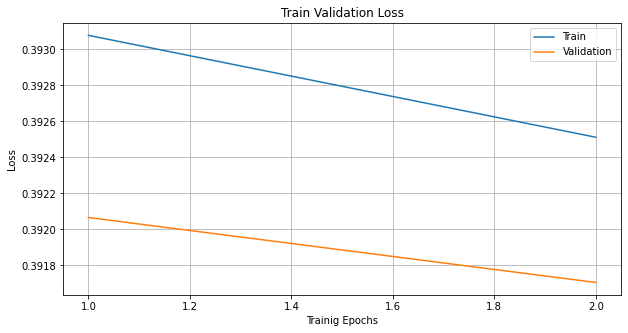

In [ ]:
plot_history(loss_history)

2


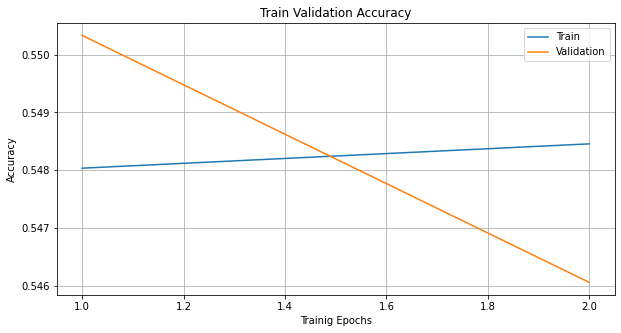

In [ ]:
plot_history(accuracy_history, False)

#3.Deploy

In [ ]:
val_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
histo_test = HistoCancerDataset('/content', val_transformer, 'test')

In [ ]:
def deploy_model(model, dataset, num_classes, sanity_check=False):
  y_out = torch.zeros(len(dataset), num_classes)
  # Y = np.zeros(len(dataset), dtype='uint8')
  model = model.to(device)
  with torch.no_grad():
    for i in range(len(dataset)):
      # x, Y[i] = dataset[i]
      y_out[i] = model(dataset[i].unsqueeze(0).to(device))
      if sanity_check:
        break
        
  return y_out.numpy()

y_test_out = deploy_model(model, histo_test, num_classes=2)

In [ ]:
cancer_preds = np.exp(y_test_out[:, 1])
sample_df = pd.read_csv('/content/sample_submission.csv')
ids_list = list(sample_df.id)
pred_list = [p for p in cancer_preds]

sub_df = pd.DataFrame({'id': sample_df['id'],
                       'label': pred_list})

sub_df.to_csv('/content/sample_submission.csv', header=True, index=False)

In [ ]:
sub_df

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.571366
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.120660
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.104136
3,2c35657e312966e9294eac6841726ff3a748febf,0.118953
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.112296
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0.968378
57454,6f3977130212641fd5808210015a609c658dcbff,0.772547
57455,46935f247278539eca74b54d07d666efb528a753,0.028812
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0.389599
